
MOTIVATION:
- Understand how well fitting works with a single feed fraction experiment. 

HYPOTHESIS:
- Low feed fractions will be difficult to fit. 


In [1]:
import numpy as np
from typing import Tuple

# import matplotlib

# matplotlib.use("webagg")
import matplotlib.pyplot as plt

from polypesto.models.CRP2 import IrreversibleCPE as Model
from polypesto.core.params import ParameterGroup
import polypesto.core.petab as pet
from polypesto.core.pypesto import create_problem_set, load_pypesto_problem
from polypesto.core.params import ParameterSet, ParameterGroup
from polypesto.utils.plot import plot_all_measurements

from pathlib import Path

import os

%load_ext autoreload
%autoreload 2

The tests rely on tellurium to construct the models
Since tellurium is not installed the tests can't be run
If you want to run the tests, pip install tellurium first


In [52]:
__file__ = "/PolyPESTO/experiments/irreversible_cpe/single_rxn/analysis.ipynb"
DIR_NAME = os.path.basename(os.path.dirname(__file__))
DATA_DIR = os.path.join(os.path.dirname(__file__), "data")


# ************** Define parameters **************
def parameters() -> ParameterGroup:
    # rA = [0.1, 0.5, 1.0, 2.0, 10.0]
    # rB = [0.1, 0.5, 1.0, 2.0, 10.0]
    rA = [3]
    rB = [10]

    pg = ParameterGroup(DIR_NAME, {})
    for _rA in rA:
        for _rB in rB:
            pg.lazy_add({"rA": _rA, "rB": _rB})

    return pg


# ************** Define experiments **************
# experimental conditions, observables, and fit parameters
def experiment(t_eval, fA0s, cM0s) -> Tuple[str, pet.PetabData]:

    dir = os.path.join(DATA_DIR, f"fA0_{fA0s[0]:.2f}")

    # Define fitting parameters
    params_dict = Model.get_default_fit_params()
    param_df = pet.define_parameters(params_dict)

    # Define experimental conditions
    cond_df = Model.create_conditions(fA0s, cM0s)
    obs_df = Model.get_default_observables()
    empty_meas_df = pet.define_empty_measurements(obs_df, cond_df, t_eval)

    return dir, pet.PetabData(
        obs_df=obs_df, cond_df=cond_df, param_df=param_df, meas_df=empty_meas_df
    )


# ************** Define experiments **************
t_eval = np.arange(0, 1, 0.1, dtype=float)
fA0s = np.array([[0.75]])
cM0s = np.array([[1.0]])

for fA0, cM0 in zip(fA0s, cM0s):

    # print(fA0, cM0)
    dir, data = experiment(t_eval, fA0, cM0)
    pg = parameters()
    print(pg)
    yaml_paths = create_problem_set(Model, parameters(), data, dir)
    # break

Visualization table not available. Skipping.
Visualization table not available. Skipping.


ParameterGroup(id='single_rxn', parameter_sets={'p_000': ParameterSet(id='p_000', parameters={'rA': Parameter(id='rA', value=3), 'rB': Parameter(id='rB', value=10)})})
Creating SBML model: irreversible_cpe
Creating irreversible CRP parameters.
                 filename : /PolyPESTO/experiments/irreversible_cpe/single_rxn/data/fA0_0.75/petab/common/irreversible_cpe.xml
         file size (byte) : 5864
           read time (ms) : 2.104759
        c-check time (ms) : 0.769854
      validation error(s) : 0
    (consistency error(s)): 0
    validation warning(s) : 0
  (consistency warning(s)): 0
Simulating data for p_000...


In [47]:
parameters()

ParameterGroup(id='single_rxn', parameter_sets={'p_000': ParameterSet(id='p_000', parameters={'rA': Parameter(id='rA', value=3), 'rB': Parameter(id='rB', value=10)})})

In [53]:
yaml_paths

{'p_000': '/PolyPESTO/experiments/irreversible_cpe/single_rxn/data/fA0_0.75/petab/p_000/petab.yaml'}

Visualization table not available. Skipping.


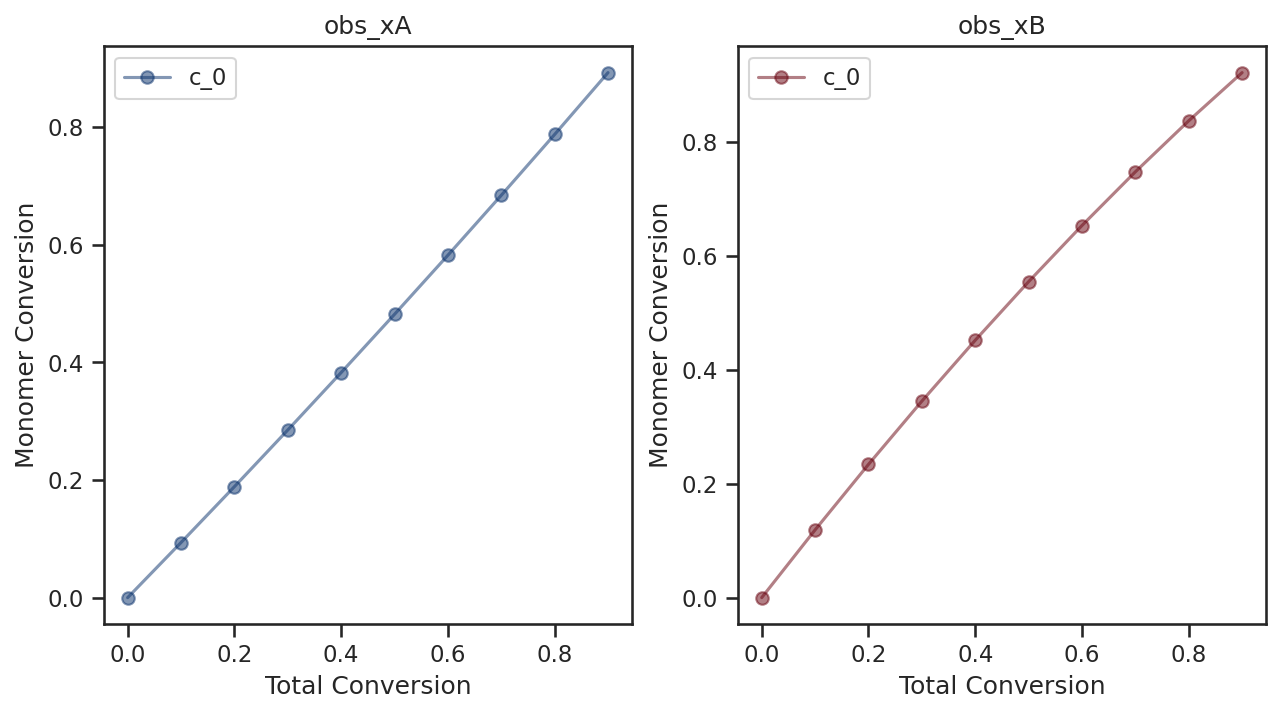

In [54]:
yaml_path = yaml_paths["p_000"]
importer, problem = load_pypesto_problem(yaml_path=yaml_path, model_name=Model.name)

plot_all_measurements(
    importer.petab_problem.measurement_df,
    # group_by=C.SIMULATION_CONDITION_ID,
    group_by=pet.C.OBSERVABLE_ID,
    format_axes_kwargs={
        "set_xlabel": "Total Conversion",
        "set_ylabel": "Monomer Conversion",
        # "set_xlim": (0, 1),
        # "set_ylim": (0, 1),
    },
    plot_style="both",
    alpha=0.5,
)
plt.show()

In [55]:
import pypesto
import pypesto.optimize as optimize
import pypesto.petab
import pypesto.sample as sample
import pypesto.visualize as visualize

optimizer = optimize.ScipyOptimizer()  # method="Nelder-Mead")  # method="Nelder-Mead")
# optimizer = optimize.PyswarmOptimizer()
history_options = pypesto.HistoryOptions(
    trace_record=True,  # storage_file="history_{id}.csv"
)
engine = pypesto.engine.MultiProcessEngine()
n_starts = 1000

# run optimization of problem 1
import amici

# problem.startpoint_method = pypesto.startpoint.LatinHypercubeStartpoints()
# problem.objective.amici_solver.setSensitivityMethod(amici.SensitivityMethod.none)
# problem.objective.amici_solver.setSensitivityOrder(amici.SensitivityOrder.first)
problem.objective.amici_solver.setMaxStepSize(1e-3)
# problem.objective.amici_model.setAlwaysCheckFinite(True)
# problem.objective.amici_solver.setSensitivityOrder(1)
# problem.objective.amici_solver.
# problem.objective.amici_solver.setSensitivityOrder(amici.SensitivityOrder.first)
optimizer = optimize.ScipyOptimizer()  # method="Nelder-Mead")  # method="Nelder-Mead")
history_options = pypesto.HistoryOptions(
    trace_record=True,  # storage_file="history_{id}.csv"
)
engine = pypesto.engine.MultiProcessEngine()
n_starts = 1000

problem.objective.amici_solver.setMaxStepSize(1e-3)
result = optimize.minimize(
    problem=problem,
    optimizer=optimizer,
    n_starts=n_starts,
    engine=engine,
    history_options=history_options,
)

Engine will use up to 8 processes (= CPU count).
Engine will use up to 8 processes (= CPU count).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:55<00:00,  4.24it/s]


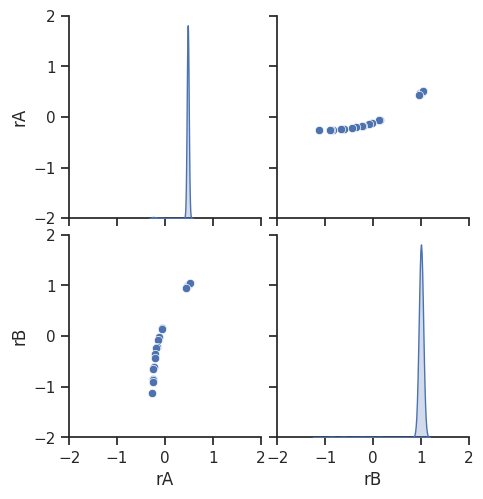

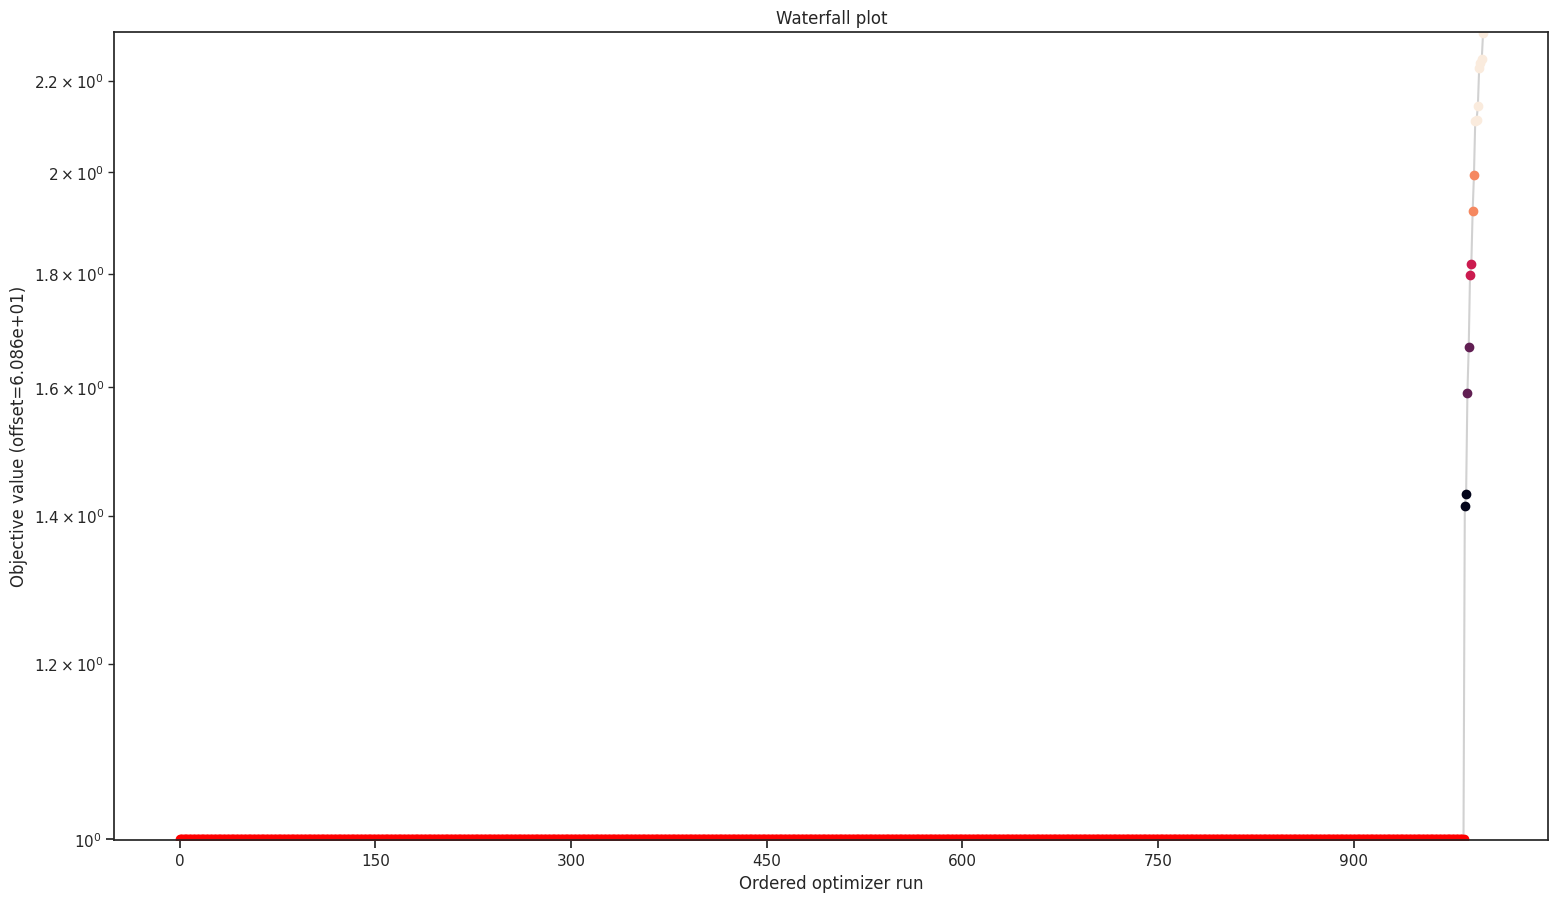

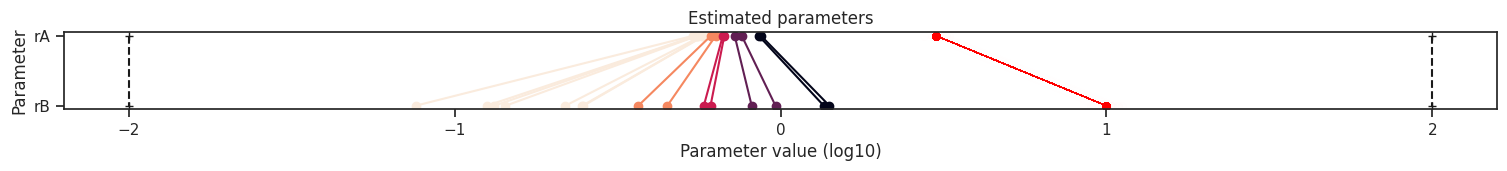

In [56]:
ax = visualize.optimization_scatter(result=result, show_bounds=True)
ax = visualize.waterfall(result)
ax = visualize.parameters(result)

In [78]:
sampler = sample.AdaptiveParallelTemperingSampler(
    internal_sampler=sample.AdaptiveMetropolisSampler(),
    # n_chains=3,
    betas=[1, 0.5, 0.1, 0.05],
    # options=dict(max_temp=10),
)
# sampler = sample.AdaptiveMetropolisSampler()
# sampler = sample.MetropolisSampler()
problem.objective.amici_solver.setMaxStepSize(1e-3)
n_samples = 10000
result = sample.sample(
    problem,
    n_samples=n_samples,
    sampler=sampler,
    # x0=result.optimize_result.list[0]["x"][0:2],
    # x0=np.array([0, 0]),
    filename=None,
    result=result,
)
elapsed_time = result.sample_result.time
print(f"Elapsed time: {round(elapsed_time,2)}")

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 488.80it/s]
Elapsed time: 20.492258797999995


Elapsed time: 20.49


In [79]:
result.sample_result

{'trace_x': array([[[0.47712567, 1.00000526],
         [0.47712567, 1.00000526],
         [0.47712567, 1.00000526],
         ...,
         [0.94129456, 1.52003516],
         [1.17186814, 1.75402165],
         [0.94129456, 1.52003516]],
 
        [[0.47712567, 1.00000526],
         [0.47712567, 1.00000526],
         [0.47712567, 1.00000526],
         ...,
         [0.246123  , 0.65460215],
         [0.94129456, 1.52003516],
         [1.17186814, 1.75402165]],
 
        [[0.47712567, 1.00000526],
         [0.47712567, 1.00000526],
         [0.47712567, 1.00000526],
         ...,
         [1.17186814, 1.75402165],
         [0.42779846, 0.95556618],
         [1.23470438, 1.95076149]],
 
        [[0.47712567, 1.00000526],
         [0.47712567, 1.00000526],
         [0.81348508, 1.275695  ],
         ...,
         [1.23470438, 1.95076149],
         [1.23470438, 1.95076149],
         [0.42779846, 0.95556618]]], shape=(4, 10001, 2)),
 'trace_neglogpost': array([[-59.86168944, -59.86168944, -59

/usr/local/lib/python3.10/dist-packages/pypesto/visualize/sampling.py:79: UserWarning: Burn in index not found in the results, the full chain will be shown.
You may want to use, e.g., `pypesto.sample.geweke_test`.
  _, params_fval, _, _, _ = get_data_to_plot(


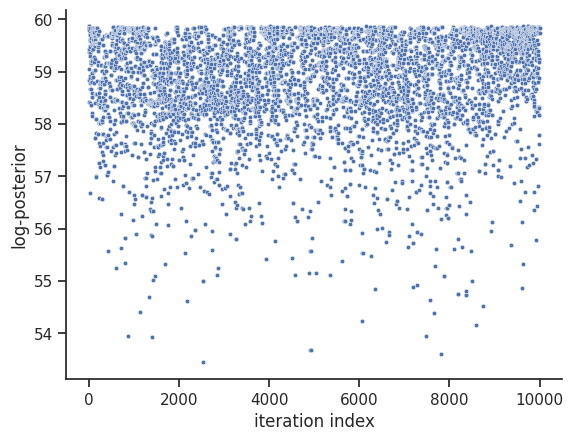

In [82]:
ax = visualize.sampling_fval_traces(result)

/usr/local/lib/python3.10/dist-packages/pypesto/visualize/sampling.py:1117: UserWarning: Burn in index not found in the results, the full chain will be shown.
You may want to use, e.g., `pypesto.sample.geweke_test`.
  nr_params, params_fval, theta_lb, theta_ub, param_names = get_data_to_plot(


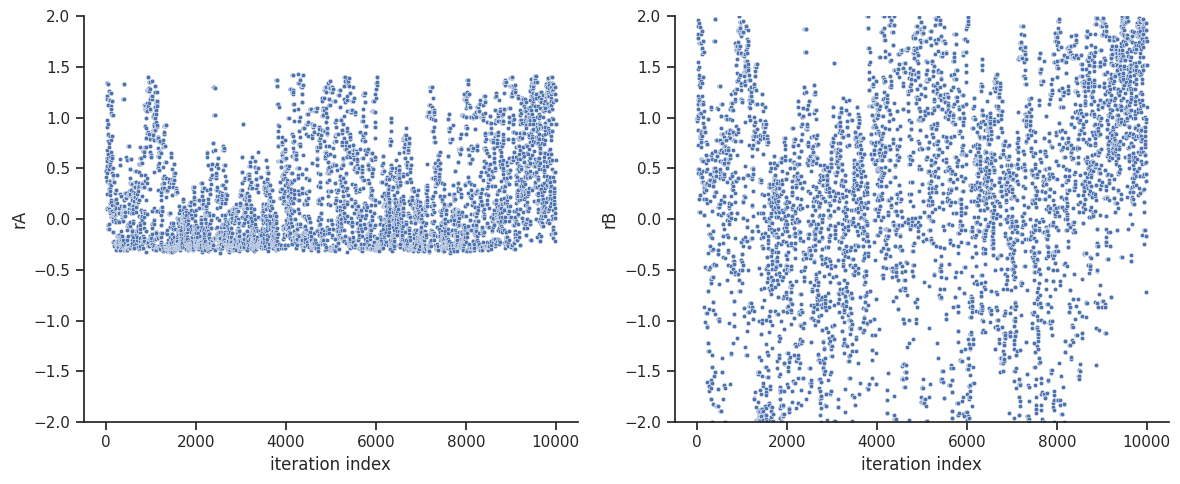

In [83]:
ax = visualize.sampling_parameter_traces(result, use_problem_bounds=True, size=(12, 5))


# pg = pg.by_id("p2").to_dict()

# ax[0][0].plot([0, n_samples], np.log10([p["rA"], p["rA"]]), "r--")
# ax[0][1].plot([0, n_samples], np.log10([p["rB"], p["rB"]]), "r--")
# ax[0][0].plot([0, n_samples], ([p["rA"], p["rA"]]), "r--")
# ax[0][1].plot([0, n_samples], ([p["rB"], p["rB"]]), "r--")
# ax[1][0].plot([0, n_samples], [p["KAA"], p["KAA"]], "r--")
# ax[1][1].plot([0, n_samples], [p["KBA"], p["KBA"]], "r--")

In [75]:
from pypesto.C import AMICI_STATUS, AMICI_T, AMICI_X, AMICI_Y
from pypesto.predict import AmiciPredictor


# This post_processor will transform the output of the simulation tool
# such that the output is compatible with the next steps.
def post_processor(amici_outputs, output_type, output_ids):
    outputs = [
        (
            amici_output[output_type]
            if amici_output[AMICI_STATUS] == 0
            else np.full((len(amici_output[AMICI_T]), len(output_ids)), np.nan)
        )
        for amici_output in amici_outputs
    ]
    return outputs


# Setup post-processors for both states and observables.
from functools import partial

amici_objective = result.problem.objective
state_ids = amici_objective.amici_model.getStateIds()
observable_ids = amici_objective.amici_model.getObservableIds()
post_processor_x = partial(
    post_processor,
    output_type=AMICI_X,
    output_ids=state_ids,
)
post_processor_y = partial(
    post_processor,
    output_type=AMICI_Y,
    output_ids=observable_ids,
)

# Create pyPESTO predictors for states and observables
predictor_x = AmiciPredictor(
    amici_objective,
    post_processor=post_processor_x,
    output_ids=state_ids,
)
predictor_y = AmiciPredictor(
    amici_objective,
    post_processor=post_processor_y,
    output_ids=observable_ids,
)

from pypesto.C import EnsembleType
from pypesto.ensemble import Ensemble

# corresponds to only the estimated parameters
x_names = result.problem.get_reduced_vector(result.problem.x_names)

# Create the ensemble with the MCMC chain from parallel tempering with the real temperature.
ensemble = Ensemble.from_sample(
    result,
    chain_slice=slice(
        None, None, 5
    ),  # Optional argument: only use every fifth vector in the chain.
    x_names=x_names,
    ensemble_type=EnsembleType.sample,
    lower_bound=result.problem.lb,
    upper_bound=result.problem.ub,
)

Geweke burn-in index: 0


In [76]:
result.sample_result.betas

array([1.00000000e+00, 1.21582519e-02, 2.00000000e-05])

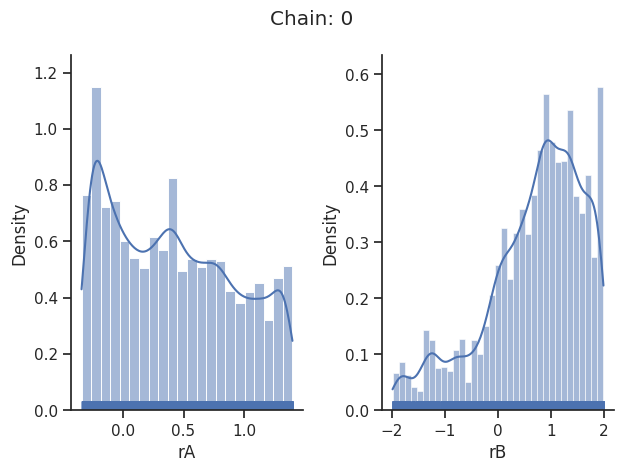

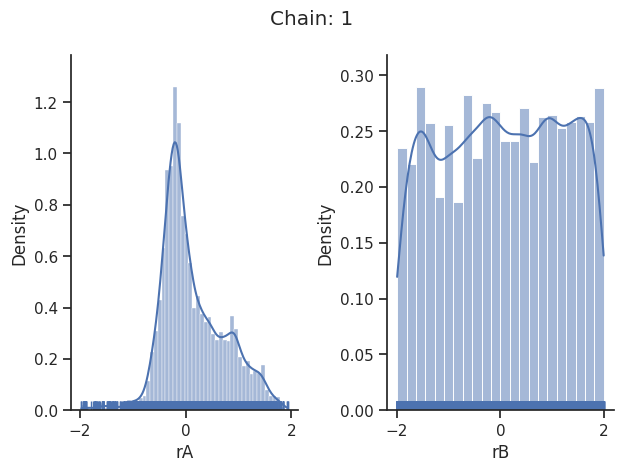

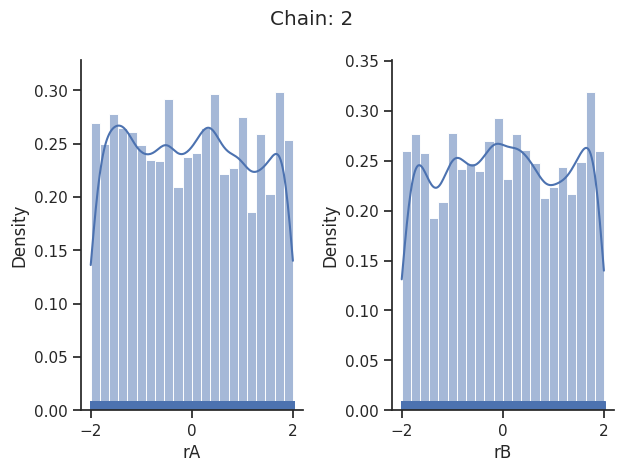

In [77]:
for i_chain in range(len(result.sample_result.betas)):
    visualize.sampling_1d_marginals(
        result,
        i_chain=i_chain,
        suptitle=f"Chain: {i_chain}",
    )

Engine will use up to 8 processes (= CPU count).


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 22.27it/s]


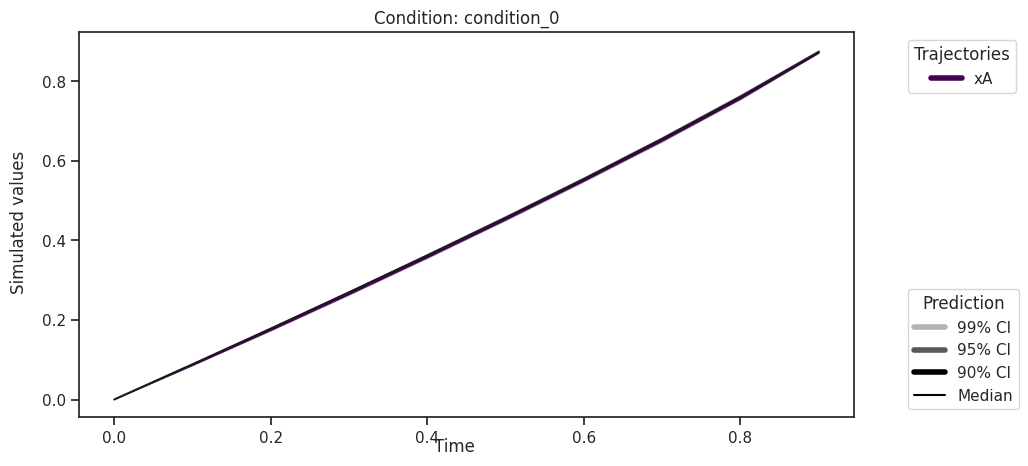

In [37]:
from pypesto.engine import MultiProcessEngine

engine = MultiProcessEngine()

ensemble_prediction = ensemble.predict(
    predictor_x, prediction_id=AMICI_X, engine=engine
)
from pypesto.C import CONDITION, OUTPUT

credibility_interval_levels = [90, 95, 99]

ax = visualize.sampling_prediction_trajectories(
    ensemble_prediction,
    levels=credibility_interval_levels,
    size=(10, 5),
    # labels={"A": "state_A", "condition_0": "cond_0"},
    axis_label_padding=60,
    groupby=CONDITION,
    # condition_ids=["condition_0", "condition_1", "condition_2"],  # `None` for all conditions
    # output_ids=["A", "B"],  # `None` for all outputs
)

In [18]:
petab_problem = importer.petab_problem

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 32.47it/s]


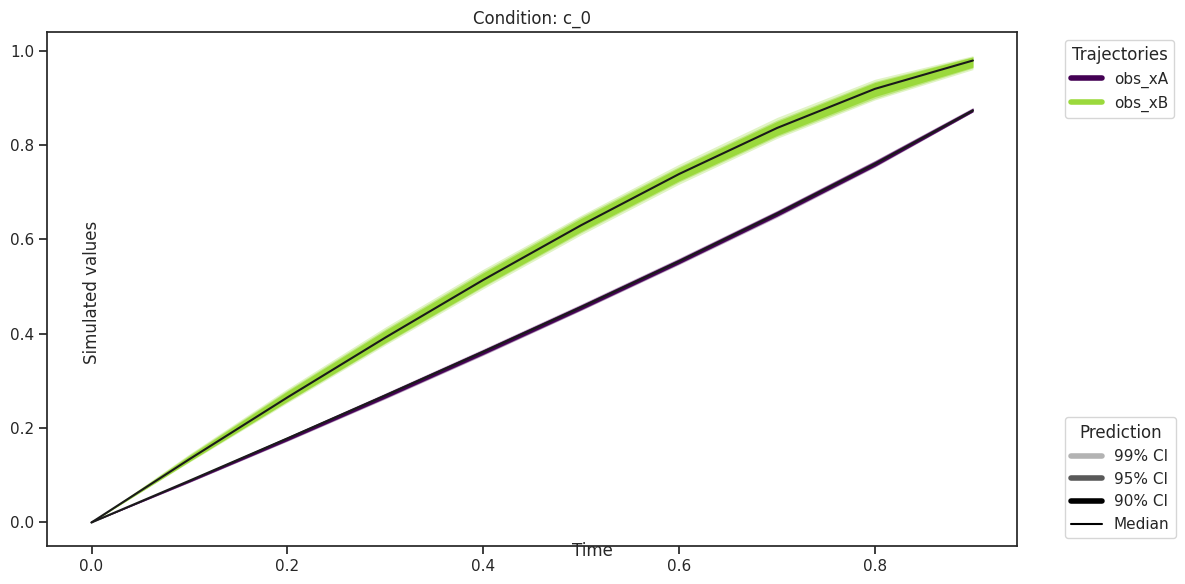

In [19]:
def show_measurement_fit(petab_problem, engine):

    mdf = petab_problem.measurement_df
    # Create a custom objective with new output timepoints.
    conditions = mdf[pet.C.SIMULATION_CONDITION_ID].unique()
    timepoints = [
        mdf[mdf[pet.C.SIMULATION_CONDITION_ID] == c][pet.C.TIME].unique()
        for c in conditions
    ]
    amici_objective_custom = amici_objective.set_custom_timepoints(
        timepoints=timepoints
    )

    # Create an observable predictor with the custom objective.
    predictor_y_custom = AmiciPredictor(
        amici_objective_custom,
        post_processor=post_processor_y,
        output_ids=observable_ids,
        condition_ids=[edata.id for edata in amici_objective_custom.edatas],
    )

    # Predict then plot.
    ensemble_prediction = ensemble.predict(
        predictor_y_custom, prediction_id=AMICI_Y, engine=engine
    )

    ax = visualize.sampling_prediction_trajectories(
        ensemble_prediction,
        levels=credibility_interval_levels,
        groupby=CONDITION,
        # measurement_df=mdf,
        size=(12, 6),
    )

    return ax


# import matplotlib.pyplot as plt
# ax[0][0].set_title('')
# ax[1][0].set_title('')
# ax[0][1].set_title('')
# # ax[1][1].set_title('')
# ax[0][0].set_ylim([-0.1, 2.1])
# ax[1][0].set_ylim([-0.1, 2.1])
# ax[0][1].set_ylim([-0.1, 2.1])
# ax[1][1].set_ylim([-0.1, 2.1])

ax = show_measurement_fit(petab_problem, engine)
plt.tight_layout()
fig = ax[0][0].get_figure()
fig.savefig("FRP2_measurement_fit.png")
plt.show()

In [31]:
def visualize_sampling_results(result, petab_problem, engine=None):
    """
    Visualize how sampled parameters predict the data with credibility intervals.

    Parameters:
    -----------
    result : pypesto.Result
        PyPESTO result object containing sampling results
    petab_problem : petab.Problem
        PEtab problem definition
    engine : pypesto.Engine, optional
        Engine for parallel computation

    Returns:
    --------
    ax : matplotlib.axes
        The axes with the plotted results
    """
    # Create an ensemble from the sampling results
    # Skip burn-in period (first 20% of samples)
    samples = result.sample_result.trace_x[0]
    burnin = int(len(samples) * 0.2)
    samples_subset = samples[burnin::10]  # Take every 10th sample to reduce computation
    print(samples_subset)

    # Create the ensemble
    ensemble = pypesto.ensemble.Ensemble(samples_subset)
    print(ensemble)
    # Get measurement data frame
    mdf = petab_problem.measurement_df

    # Extract unique conditions and timepoints
    conditions = mdf[pet.C.SIMULATION_CONDITION_ID].unique()
    timepoints = [
        mdf[mdf[pet.C.SIMULATION_CONDITION_ID] == c][pet.C.TIME].unique()
        for c in conditions
    ]
    print(timepoints)
    # Create custom objective with these timepoints
    amici_objective_custom = result.problem.objective.set_custom_timepoints(
        timepoints=timepoints
    )

    # Define the observable IDs (based on your model)
    observable_ids = petab_problem.observable_df.index.tolist()

    # Create predictor with the custom objective
    predictor_y_custom = pypesto.predict.AmiciPredictor(
        amici_objective_custom,
        # Use appropriate post-processor for your model
        condition_ids=[edata.id for edata in amici_objective_custom.edatas],
        output_ids=observable_ids,
    )

    # Define credibility interval levels
    credibility_interval_levels = [0.5, 0.95]  # 50% and 95% CI

    # Predict then plot
    ensemble_prediction = ensemble.predict(
        predictor_y_custom,  # prediction_id="y_model", engine=engine
    )

    # Create visualizations
    ax = pypesto.visualize.sampling_prediction_trajectories(
        ensemble_prediction,
        levels=credibility_interval_levels,
        groupby="condition",
        measurement_df=mdf,  # Include measurements
        size=(12, 6),
    )

    # Customize the plot if needed
    for row in ax:
        for subplot in row:
            subplot.set_ylim([-0.1, 2.1])  # Adjust based on your data range

    plt.tight_layout()
    return ax


petab_problem = importer.petab_problem
visualize_sampling_results(result, petab_problem)

[[-0.30112783  0.01475155]
 [-0.31431681 -0.09716697]
 [-0.39418359 -0.37288301]
 ...
 [-0.37327169 -0.20014875]
 [-0.29470033  0.05037116]
 [-0.29470033  0.05037116]]
[array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])]


  0%|                                                                                                                | 0/2 [00:00<?, ?it/s]


ValueError: shape mismatch: value array of shape (0,) could not be broadcast to indexing result of shape (2,)

In [25]:
samples = result.sample_result.trace_x[0]
samples[10::10]

array([[-0.31629117, -0.04771733],
       [-0.31783737, -0.03375735],
       [-0.32395645, -0.07154124],
       ...,
       [-0.37327169, -0.20014875],
       [-0.29470033,  0.05037116],
       [-0.29470033,  0.05037116]], shape=(1000, 2))